Análisis de frecuencia de palabras según subtítulos de videos (ejecutar primero subs_to_matrix.py para generar los archivos necesarios)

In [75]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Set, Dict, Tuple, Callable

# tokens_freq contains total frequency for each token
# file_texts contains for each file a dictionary where the keys are the tokens present in the file and the values are the frequence
TokenDict = Dict[str, float]
FileDict = Dict[str, Dict[str, int]]

data = 'data/'
with open(data + 'tokens_freq.json') as tokens_file:
  tokens_freq: TokenDict = { k: float(v) for k, v in json.load(tokens_file).items()}
with open(data + 'file_texts.json') as files_file:
  file_texts: FileDict = json.load(files_file)

# vids_l contains duration in hours for each video
vids_l: Dict[str, float] = {}
for f in file_texts:
    with open('CleanSubs/' + f) as f_subs:
        vlen = list(f_subs)[-1].split(',')[1].split(':')
        if(len(vlen) == 3):
            vids_l[f] = float(vlen[0]) + float(vlen[1])/60 + float(vlen[2])/(60*60)

In [2]:
def filter_words_by_freq(d: TokenDict, freq: int) -> Tuple[TokenDict, TokenDict]:
    '''Filter words from word dict d that have frequency lower than freq'''
    filtered = dict()
    remaining = dict()
    for k, v in d.items():
        if v >= freq:
            remaining[k] = v
        else:
            filtered[k] = v
    return remaining, filtered

def filter_files_by_words(files: FileDict, filtered_words: TokenDict) -> Tuple[FileDict, FileDict]:
    '''Filter files which contain words in filtered_words'''
    remaining: FileDict = {}
    filtered: FileDict = {}
    for t, f in files.items():
        for word in filtered_words:
            if word in f:
                filtered[t] = f
                break
        if not filtered.get(t, False):
            remaining[t] = f
    return remaining, filtered

def filtered_to_perc(rf: Tuple[List[dict], List[dict]]) -> float:
    '''Gets a tuple of (remaining, filtered) and returns percent of remaining over total'''
    return 100 * len(rf[1]) / (len(rf[0]) + len(rf[1]))

def total_time(vids: List[str], vids_l: Dict[str, float]) -> float:
    '''Returns for list of videos the total length acording to lengths stored in vids_l'''
    return sum(map(lambda f: vids_l.get(f, 0), vids))

def gen_words_by_limits(file_texts: FileDict, lims: Tuple[int, int]) -> Tuple[List[int], List[int], List[int]]:
    '''Generates tuple contains 3 lists corresponding to the ammount of tokens according to each frequency lims[i] in each video'''
    words_by_limits: Tuple[List[int], List[int], List[int]] = tuple([0 for _ in file_texts.keys()] for i in range(3))
    for i, (f, words) in enumerate(file_texts.items()):
        for word in words:
            words_by_limits[0 if tokens_freq[word] < lims[0] else 1 if tokens_freq[word] < lims[1] else 2][i] += 1
    return words_by_limits

def gen_stacked_and_perc_df(file_texts: FileDict, lims: Tuple[int, int]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    wbls = gen_words_by_limits(file_texts, lims)
    wbls_perc = [[q*100/(wbls[0][i] + wbls[1][i] + wbls[2][i]) for i, q in enumerate(wbl)] for wbl in wbls]
    df_wbls = pd.DataFrame({labels[i]: wbls[i] for i in range(3)}, index=file_texts).sort_values(by=list(labels), ascending=False)
    df_wbls_perc = pd.DataFrame({labels[i]: wbls_perc[i] for i in range(3)}, index=file_texts).sort_values(by=list(labels), ascending=False)
    return df_wbls, df_wbls_perc

Análisis de la frecuencia de aparición de cada token del vocabulario

count    54025.000000
mean        23.093642
std        156.434752
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max      10818.000000
Name: Word Frequency, dtype: float64

si            10818.0
              10178.0
bueno          8299.0
va             7201.0
ver            5453.0
ahora          5113.0
vamos          4705.0
hoy            4651.0
ser            4401.0
así            4377.0
entonces       3909.0
argentina      3874.0
bien           3757.0
gobierno       3730.0
momento        3723.0
dos            3698.0
puede          3634.0
día            3560.0
buenos         3477.0
hace           3451.0
años           3401.0
presidente     3399.0
hacer          3384.0
país           3225.0
tener          3222.0
decir          3199.0
año            3179.0
después        3141.0
personas       3013.0
ciudad         3003.0
Name: Word Frequency, dtype: float64

/home/pedroodb/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

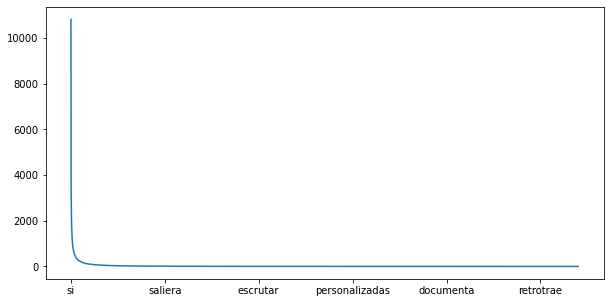

In [83]:
s_word_freqs = pd.Series(tokens_freq, name="Word Frequency").sort_values(ascending=False)
display(s_word_freqs.describe())
display(s_word_freqs.head(30))
display(s_word_freqs.plot(figsize=(10,5)))

Zoom en el gráfico anterior

/home/pedroodb/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

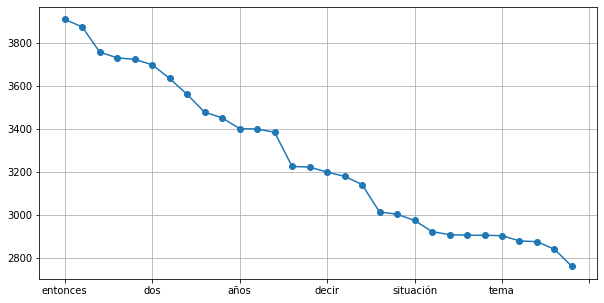

In [40]:
s_word_freqs.iloc[10:40].plot(marker='o', grid=True, figsize=(10,5))

Porcentaje de tokens filtrados sobre el total al variar la frecuencia minima 

count    100.000000
mean      88.196909
std       15.633513
min        0.000000
25%       88.686719
50%       93.192966
75%       95.094401
max       96.155484
Name: Percent of words filtered by frequency, dtype: float64

<AxesSubplot:>

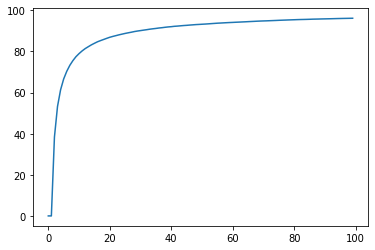

In [4]:
# filtered_words contains list of (remaining, filtered) tokens when filtering by frequency from 0 to 100
filtered_words: List[Tuple[TokenDict, TokenDict]] = [filter_words_by_freq(tokens_freq, i) for i in range(100)]

filtered_word_percents = map(filtered_to_perc, filtered_words)
s_filtered_word_percents = pd.Series(filtered_word_percents, name="Percent of words filtered by frequency")
display(s_filtered_word_percents.describe())
display(s_filtered_word_percents.plot())

Porcentaje de videos filtrados al variar frecuencia mínima para filtrar palabra

count    100.000000
mean      97.791713
std       14.071678
min        0.000000
25%       99.944009
50%       99.944009
75%       99.944009
max       99.944009
Name: Percent of files filtered by frequency, dtype: float64

<AxesSubplot:>

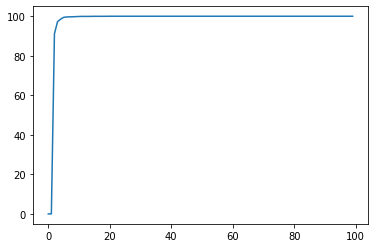

In [5]:
# filtered_words contains list of (remaining, filtered) files dictionaries when filtering by tokens in filtered_words
filtered_files: List[Tuple[TokenDict, TokenDict]] = [filter_files_by_words(file_texts, f_tokens[1]) for f_tokens in filtered_words]

# filtered_files_percents contain percent of each item from filtered_files over total files
filtered_files_percents = map(filtered_to_perc, filtered_files)
s_filtered_files_percent = pd.Series(filtered_files_percents, name="Percent of files filtered by frequency")
display(s_filtered_files_percent.describe())
display(s_filtered_files_percent.plot())

Zoom en el gráfico anterior

<AxesSubplot:>

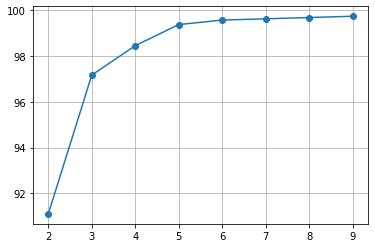

In [6]:
s_filtered_files_percent.iloc[2:10].plot(marker='o', grid=True)

Mismo análisis pero en función del tiempo en lugar del porcentaje

count    100.000000
mean       5.671719
std       38.924007
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      276.690413
Name: Hours by word frequency filtered, dtype: float64

<AxesSubplot:>

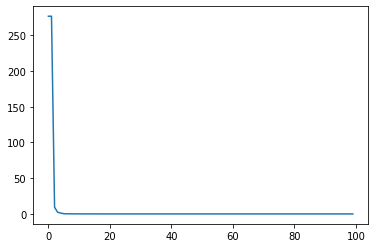

In [7]:
# filtered_files_hours contain length in hours of each item from filtered_files
filtered_files_hours = [total_time(rem.keys(), vids_l) for rem, fil in filtered_files]
s_filtered_files_hours = pd.Series(filtered_files_hours, name="Hours by word frequency filtered")
display(s_filtered_files_hours.describe())
display(s_filtered_files_hours.plot())

Zoom en el gráfico anterior 

<AxesSubplot:>

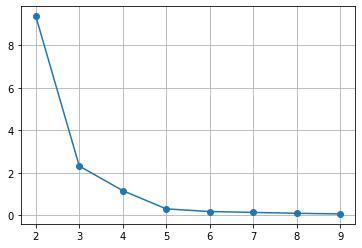

In [8]:
s_filtered_files_hours.iloc[2:10].plot(marker='o', grid=True)

Gráfico de barras con los videos en el eje x donde se le asocian la cantidad de palabras coloreadas segun su frecuencia. Luego el gráfico se replica pero en función del porcentaje en lugar de la cantidad total.

Showing 50 of 3572 videos


<AxesSubplot:>

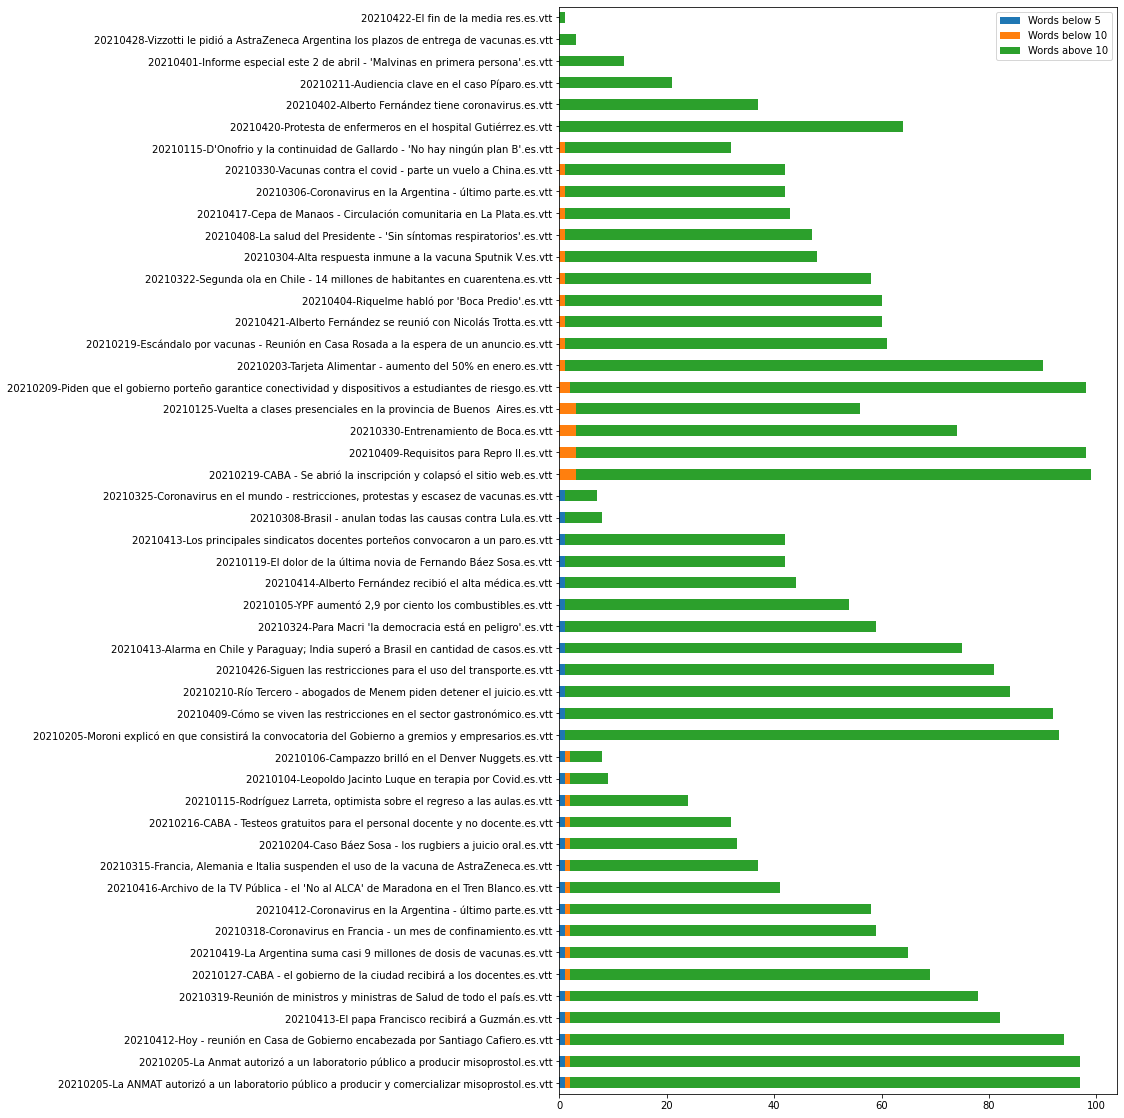

In [21]:
SHOW = 50
LIMS: Tuple[int, int] = 5, 10
labels: Tuple[str, str, str] = 'Words below {}'.format(LIMS[0]), 'Words below {}'.format(LIMS[1]), 'Words above {}'.format(LIMS[1]), 

df_videos_tokens_frequency, df_vtf_percents = gen_stacked_and_perc_df(file_texts, LIMS)

print("Showing {} of {} videos".format(SHOW, len(file_texts)))
df_videos_tokens_frequency.iloc[-SHOW:].plot.barh(stacked=True, figsize=(10,20))

Showing 100 of 3572 videos


<AxesSubplot:>

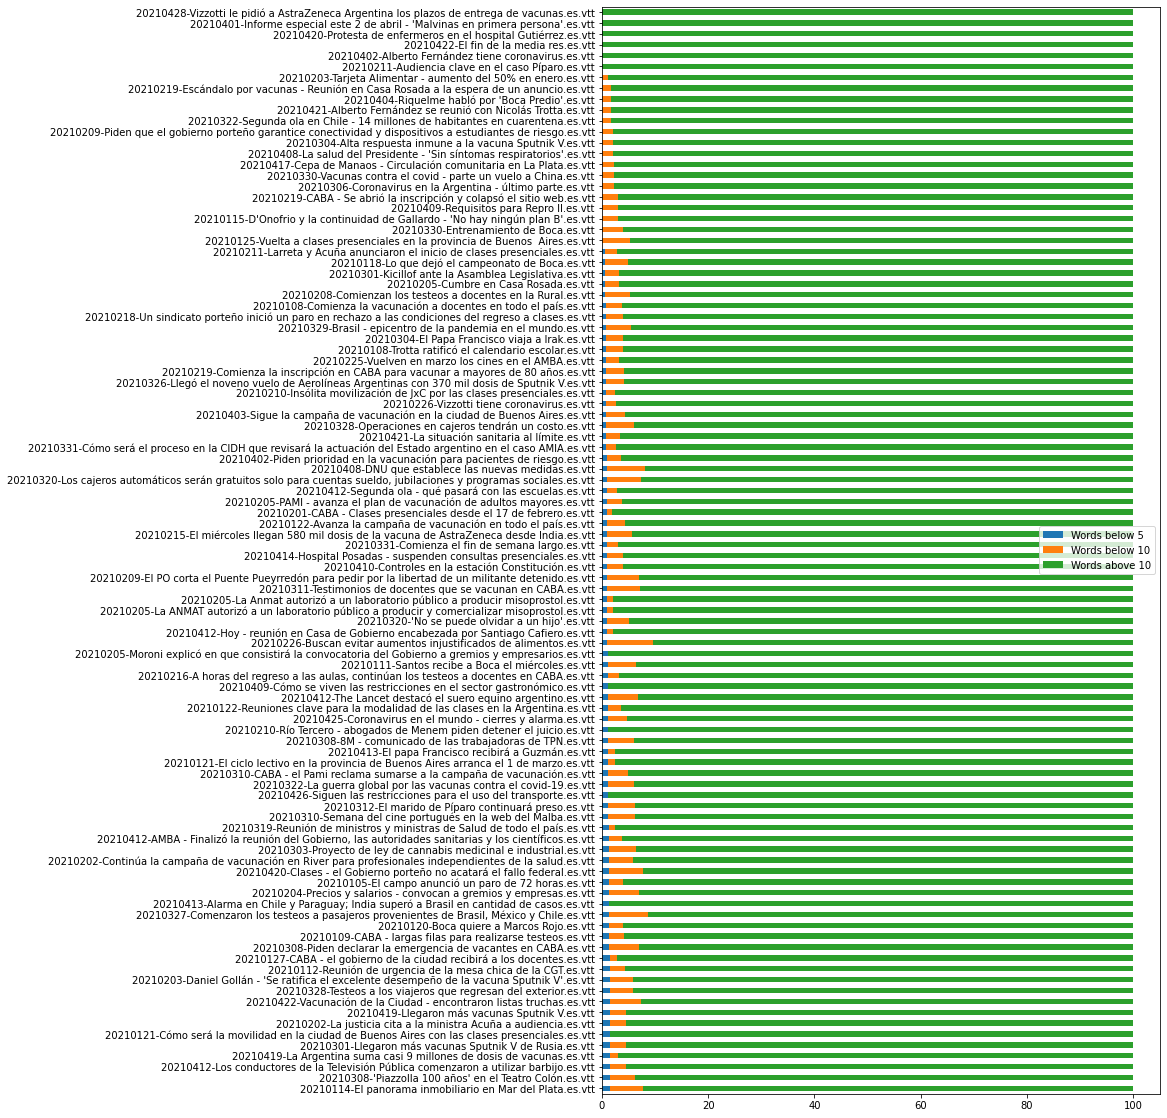

In [32]:
SHOW_P = 100

print("Showing {} of {} videos".format(SHOW_P, len(file_texts)))
df_vtf_percents.iloc[-SHOW_P:].plot.barh(stacked=True, figsize=(10,20))

Mismos gráficos que los anteriores pero ahora tomando los videos que no utilizan palabras con frecuencia menor a FREQ_LIMIT

318 videos restantes, total de 9.357594166666663 horas
Showing 318 videos


<AxesSubplot:>

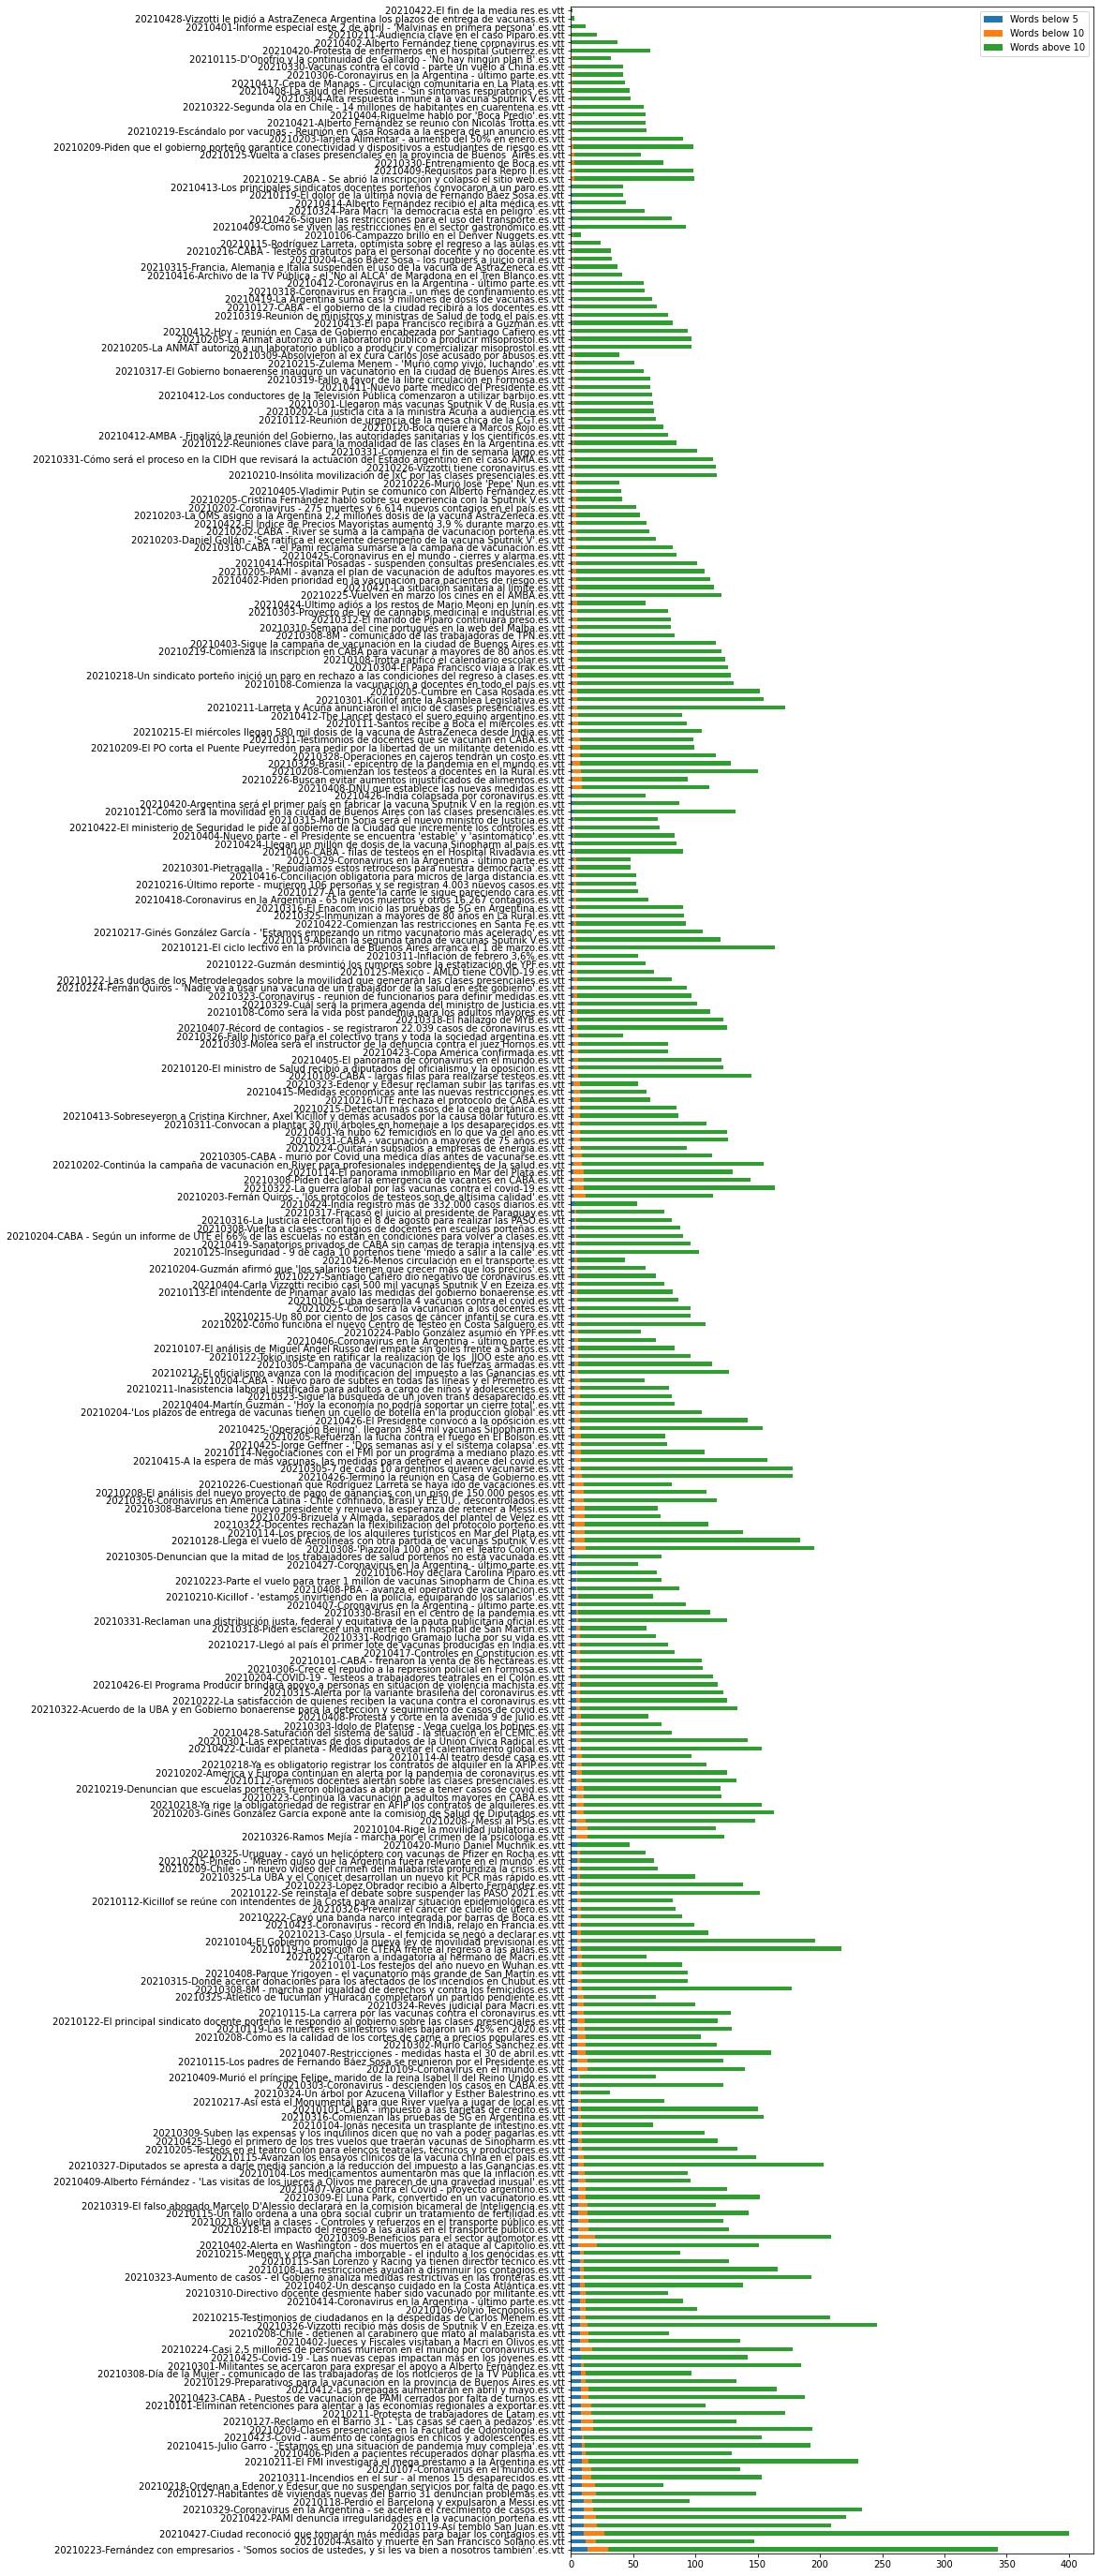

In [11]:
FREQ_LIMIT = 2
f_file_texts: FileDict = filtered_files[FREQ_LIMIT][0]
f_times: Dict[str, float] = {f: vids_l.get(f, 0) for f in f_file_texts.keys()}
print('{} videos restantes, total de {} horas'.format(len(f_file_texts), sum(f_times.values())))

df_f_vtf, df_f_vtf_percents = gen_stacked_and_perc_df(f_file_texts, LIMS)

print("Showing {} videos".format(len(f_file_texts)))
df_f_vtf.plot.barh(stacked=True, figsize=(10,50))

Showing 318 videos


<AxesSubplot:>

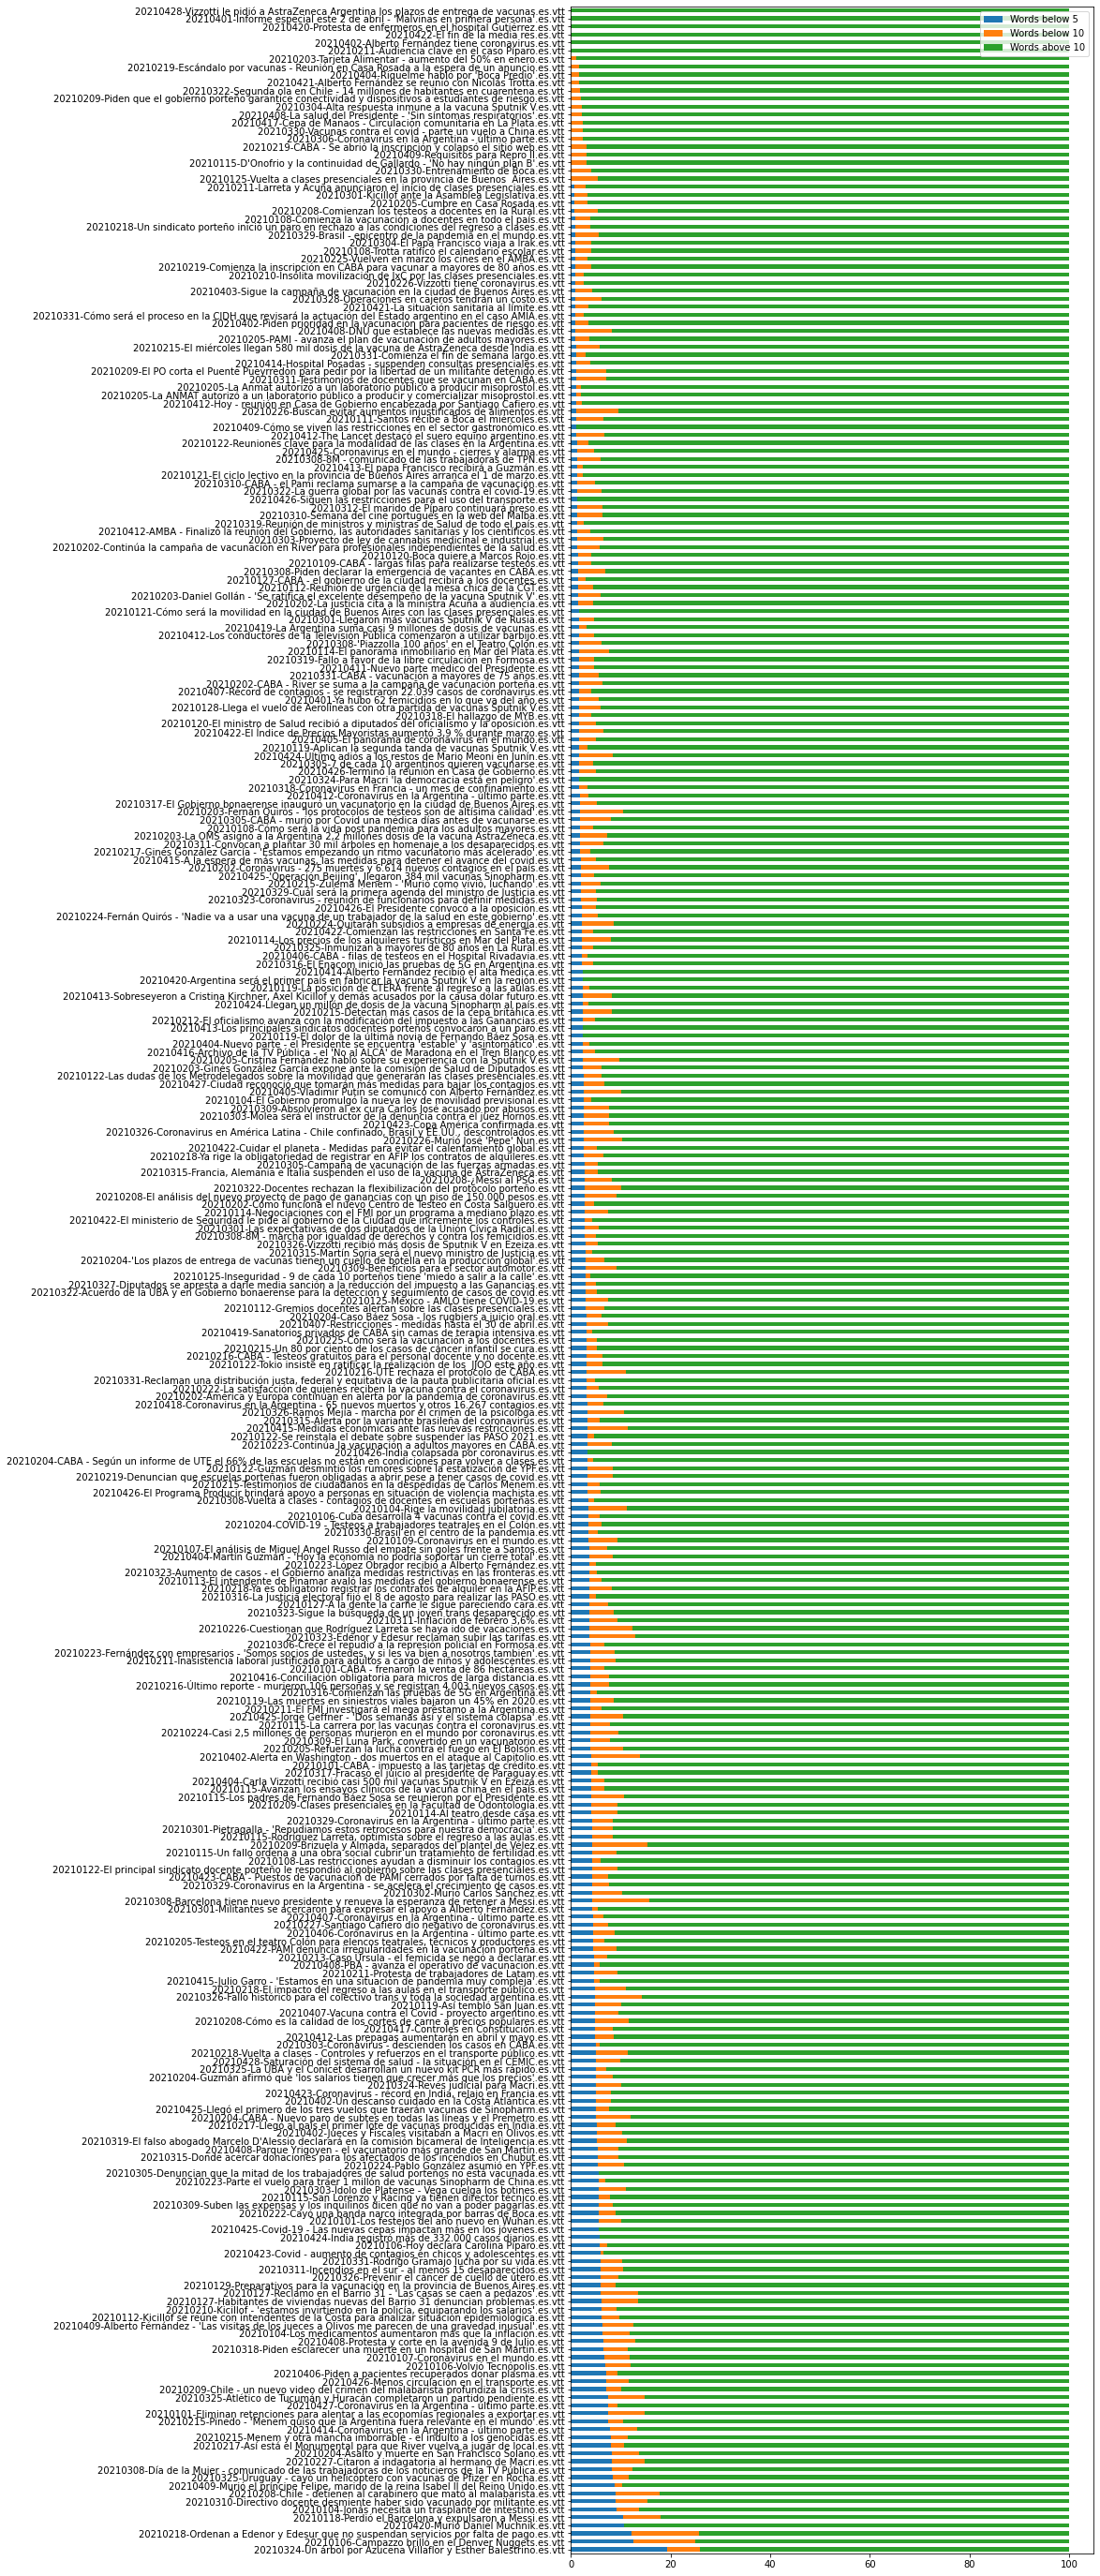

In [12]:
print("Showing {} videos".format(len(f_file_texts)))
df_f_vtf_percents.plot.barh(stacked=True, figsize=(10,50))

A continuación se toman las palabras más frecuentes y se filtran los videos en función de los que NO contienen alguna de las las N palabras más frecuentes.

In [13]:
w_index: List[str] = [''] + list(map(lambda p: p[0], list(s_word_freqs.items())[:100]))
w_series: List[float] = []

files_remaining: FileDict = file_texts
for word in w_index:
    w_series.append(total_time(files_remaining, vids_l))
    files_remaining = {t: f for t, f in files_remaining.items() if word in f}

s_hours_by_filtering_words = pd.Series(w_series, index=enumerate(w_index), name="Hours by filtering most frequent words")

s_hours_by_filtering_words.describe()

count    101.000000
mean      20.305087
std       44.134123
min        0.000000
25%        0.000000
50%        1.239236
75%       15.112274
max      276.690413
Name: Hours by filtering most frequent words, dtype: float64

El siguiente gráfico muestra sobre el eje y la cantidad de horas totales de los videos que contienen todas las palabras desde la más frecuente hasta la palabra x (ordenadas por frecuencia)

/home/pedroodb/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

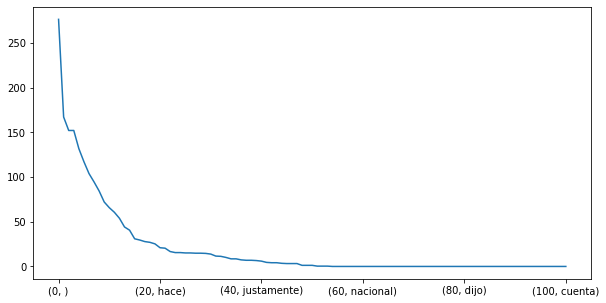

In [14]:
s_hours_by_filtering_words.plot(figsize=(10,5))

/home/pedroodb/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


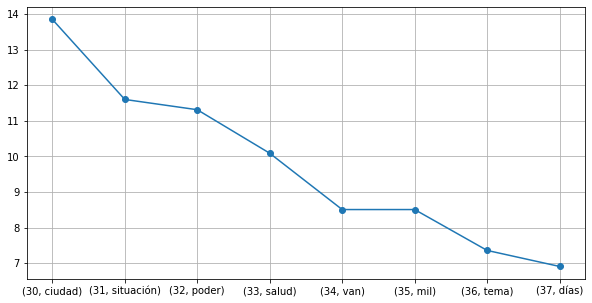

In [109]:
ax = s_hours_by_filtering_words.iloc[30:38].plot(marker='o', grid=True, figsize=(10,5))

Se toman los videos que se obtienen al recortar hasta la última palabra antes de que queden menos de 10hs

Showing 15 videos


<AxesSubplot:>

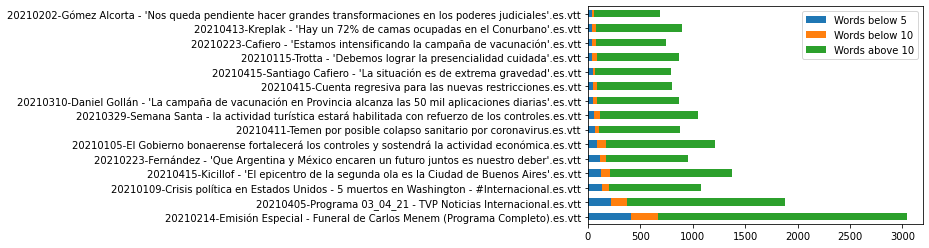

In [112]:
WORD_LIMIT_IDX = 34

words_cut: List[str] = w_index[1:WORD_LIMIT_IDX]
files_cut: FileDict = {t: f for t, f in file_texts.items() if all(map(lambda w: w in f, words_cut))}

df_vc, df_vc_percents = gen_stacked_and_perc_df(files_cut, LIMS)

print("Showing {} videos".format(len(files_cut)))
df_vc.plot.barh(stacked=True)

Showing 15 videos


<AxesSubplot:>

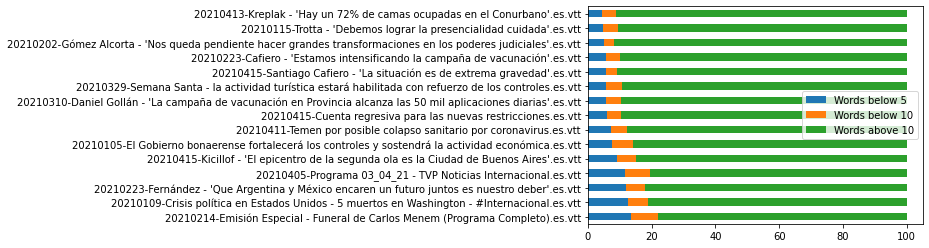

In [17]:
print("Showing {} videos".format(len(files_cut)))
df_vc_percents.plot.barh(stacked=True)

In [33]:
pos_to_percent = lambda df, f: 100 * (len(df.index) - list(df.index).index(f)) / len(df.index)

df_cut_to_tf = pd.DataFrame({
    'pos_at_token_freq': [pos_to_percent(df_videos_tokens_frequency, f) for f in files_cut],
    'pos_at_token_freq_perc': [pos_to_percent(df_vtf_percents, f) for f in files_cut]
}, index=files_cut)

display(df_cut_to_tf.head(15))

pos_at_token_freq  \
20210115-Trotta - 'Debemos lograr la presencial...          94.260918   
20210214-Emisión Especial - Funeral de Carlos M...         100.000000   
20210413-Kreplak - 'Hay un 72% de camas ocupada...          93.309071   
20210329-Semana Santa - la actividad turística ...          98.012318   
20210310-Daniel Gollán - 'La campaña de vacunac...          96.612542   
20210415-Santiago Cafiero - 'La situación es de...          95.212766   
20210411-Temen por posible colapso sanitario po...          98.488242   
20210109-Crisis política en Estados Unidos - 5 ...          99.916013   
20210105-El Gobierno bonaerense fortalecerá los...          99.468085   
20210405-Programa 03_04_21 - TVP Noticias Inter...          99.944009   
20210202-Gómez Alcorta - 'Nos queda pendiente h...          90.509518   
20210415-Kicillof - 'El epicentro de la segunda...          99.832027   
20210223-Fernández - 'Que Argentina y México en...          99.776036   
20210223-Cafiero - 'Estamos intensificando la c...          94.036954   
20210415-Cuenta regresiva para las nuevas restr...          96.388578   

                                                    pos_at_token_freq_perc  
20210115-Trotta - 'Debemos lograr la presencial...               29.451288  
20210214-Emisión Especial - Funeral de Carlos M...               96.528555  
20210413-Kreplak - 'Hay un 72% de camas ocupada...               23.544233  
20210329-Semana Santa - la actividad turística ...               41.489362  
20210310-Daniel Gollán - 'La campaña de vacunac...               42.525196  
20210415-Santiago Cafiero - 'La situación es de...               41.153415  
20210411-Temen por posible colapso sanitario po...               61.226204  
20210109-Crisis política en Estados Unidos - 5 ...               95.016797  
20210105-El Gobierno bonaerense fortalecerá los...               64.977604  
20210405-Programa 03_04_21 - TVP Noticias Inter...               92.413214  
20210202-Gómez Alcorta - 'Nos queda pendiente h...               32.782755  
20210415-Kicillof - 'El epicentro de la segunda...               78.555431  
20210223-Fernández - 'Que Argentina y México en...               93.029115  
20210223-Cafiero - 'Estamos intensificando la c...               38.829787  
20210415-Cuenta regresiva para las nuevas restr...               47.424412